## 1. 데이터 준비

In [1]:
%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import ConvNet
from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_not_contain_every_class, split_contain_every_class, generate_server_idcs, CustomSubset


torch.manual_seed(42)
np.random.seed(42)

실험 검증
1. predicted label
2. client acc
3. 가장 좋은 지표 0.3 이상 -> 아니면 분류 의미 X

We will run experiments with the EMNIST data set of handwritten characters. We simulate a scenario with 10 clients and distribute the data among the clients in a non-iid way accoding to a dirichlet distribution parametrized with alpha=1.0 . The distribution of data is shown below.

MNIST dataset

In [2]:
N_CLIENTS = 9
DIRICHLET_ALPHA = 1.0

data = datasets.MNIST(root="MNIST/", download=True)

mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

idcs = np.random.permutation(len(data))

train_idcs, test_idcs = idcs[:10000], idcs[10000:12000]
train_labels = data.train_labels.numpy()
test_labels = data.train_labels.numpy()[10000:]

client_idcs = split_contain_every_class(train_idcs, train_labels, n_clients=N_CLIENTS, data_per_class = 50, Imbalance_ratio = 2)
server_idcs = generate_server_idcs(test_idcs, test_labels)

client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

/home/jovyan/.venv/torch1.12.1-py3.8-cuda11.3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


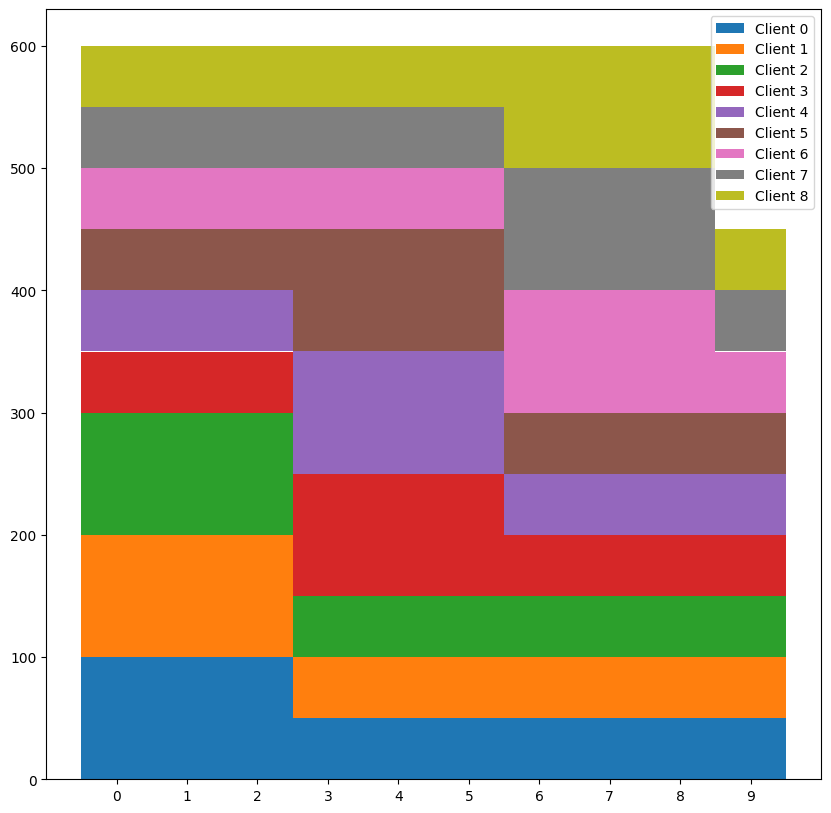

In [3]:
plt.figure(figsize=(10,10))
plt.hist([train_labels[idc]for idc in client_idcs], stacked=True, 
         bins=np.arange(min(train_labels)-0.5, max(train_labels) + 1.5, 1),
        label=["Client {}".format(i) for i in range(N_CLIENTS)])
plt.xticks(np.arange(10), mapp)
plt.legend()
plt.show()

Next, we simulate a clustering structure in the client population, by rotating the data for half of the first 5 clients by 180 degree. We display 10 data samples from the 1st and the 6th client for illustration.

In [4]:
for i, client_datum in enumerate(client_data):
    client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])
    

server = Server(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9),test_data)
distillation_data = server.make_distillation_data()
clients = [Client(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, distillation_data, idnum=i) 
           for i, dat in enumerate(client_data)]


Client 5:


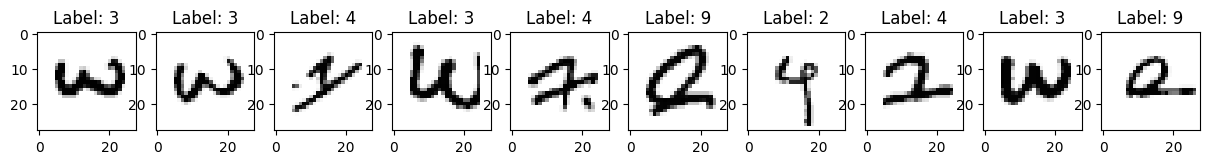

Client 0:


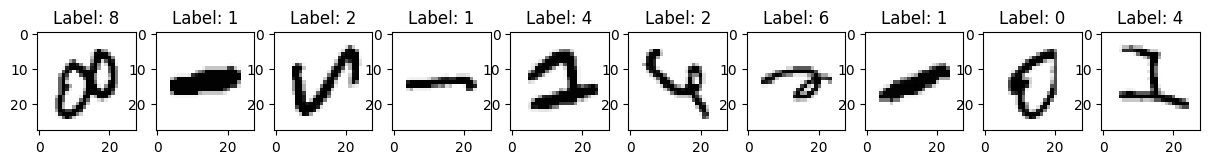

In [5]:
for client in [clients[5], clients[0]]:
    x, y = iter(client.train_loader).next()

    print("Client {}:".format(client.id))
    plt.figure(figsize=(15,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i,0].numpy().T, cmap="Greys")
        plt.title("Label: {}".format(mapp[y[i].item()]))
    plt.show()

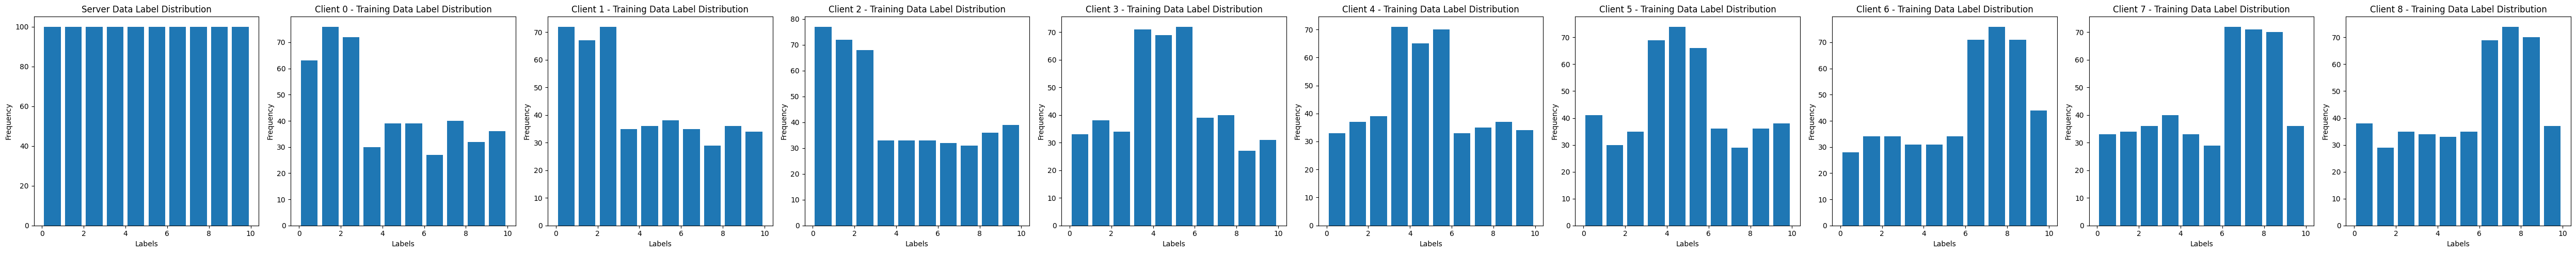

In [6]:
fig, axs = plt.subplots(1, len(clients) + 1, figsize=(5 * (len(clients) + 1), 5))

# Plot Server Data first
all_labels = []
for x, y in server.loader:
    labels = y.numpy()
    all_labels.extend(labels)
axs[0].hist(all_labels, bins=10, range=(0,10), rwidth=0.8)
axs[0].set_title("Server Data Label Distribution")
axs[0].set_xlabel("Labels")
axs[0].set_ylabel("Frequency")

# Loop over client's training data
for j, client in enumerate(clients):
    all_labels = []
    for x, y in client.train_loader:
        labels = y.numpy()
        all_labels.extend(labels)
        
    axs[j+1].hist(all_labels, bins=10, range=(0,10), rwidth=0.8)
    axs[j+1].set_title("Client {} - Training Data Label Distribution".format(client.id))
    axs[j+1].set_xlabel("Labels")
    axs[j+1].set_ylabel("Frequency")

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


Now everything is set up to run our Clustered Federated Learning algorithm. During training, we will track the mean and std client accuracies, as well as the average and maximum client update norms.

## 2)train client model

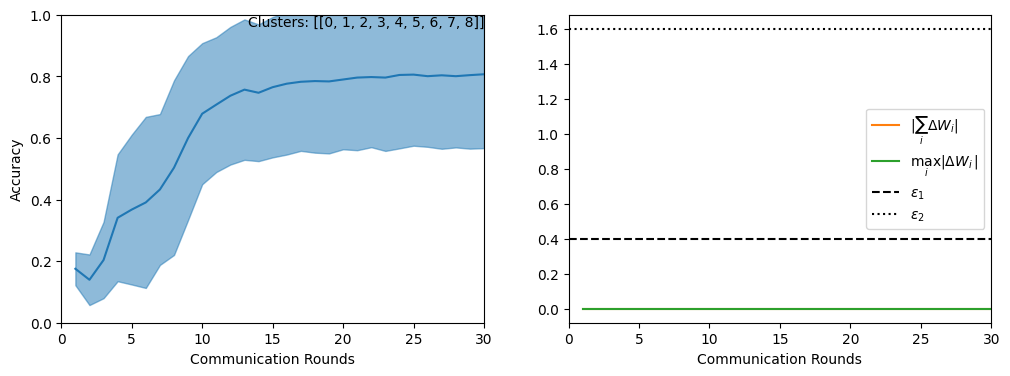

communication cost: 0.0, accuracy: 0.8066893424036281


In [7]:
COMMUNICATION_ROUNDS = 30
EPS_1 = 0.4
EPS_2 = 1.6
    
def aggregate(cluster_indices_new):
    cluster_indices = cluster_indices_new
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

    server.aggregate_clusterwise(client_clusters)
    
    return cluster_indices
    
cfl_stats = ExperimentLogger()
    
cluster_indices = [np.arange(len(clients)).astype("int")]
client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]


for c_round in range(1, COMMUNICATION_ROUNDS+1):

    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)
            
    participating_clients = server.select_clients(clients, frac=1.0)

    for client in participating_clients:
        train_stats = client.compute_weight_update(epochs=1) #train client
        if c_round == 1000:
            client.reset()

    cluster_indices_new = []
    
    for idc in cluster_indices:
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
            
        #cluster 나누는 기준
        if c_round == COMMUNICATION_ROUNDS: #무조건 한번 나누기
            similarities = server.compute_pairwise_similarities(clients)
            
            server.cache_model(idc, clients[idc[0]].W, acc_clients)
            
            c1, c2, c3 = server.cluster_clients_GMM(similarities[idc][:,idc])
            cluster_indices_new += [c1, c2, c3]
            
    if c_round == 1000:
        cluster_indices = aggregate(cluster_indices_new)

    acc_clients = [client.evaluate() for client in clients]
    if c_round == COMMUNICATION_ROUNDS: #무조건 한번 나누기
        label_accuracies = pd.DataFrame()
        label_predicted = pd.DataFrame()
        label_soft_sum = pd.DataFrame()
        label_diff = pd.DataFrame()

        for i, client in enumerate(clients):
            acc, pred, sum_, diff = server.evaluate(client.model)
            # Convert each dictionary to a DataFrame and append to the respective DataFrame
            label_accuracies = label_accuracies.append(pd.DataFrame(acc, index=[i]))
            label_predicted = label_predicted.append(pd.DataFrame(pred, index=[i]))
            label_soft_sum = label_soft_sum.append(pd.DataFrame(sum_, index=[i]))
            label_diff = label_diff.append(pd.DataFrame(diff, index=[i]))

        # Reset index for all DataFrames
        label_accuracies.reset_index(drop=True, inplace=True)
        label_predicted.reset_index(drop=True, inplace=True)
        label_soft_sum.reset_index(drop=True, inplace=True)
        label_diff.reset_index(drop=True, inplace=True)


    average_dw = server.get_average_dw(clients)
    print(average_dw)
    cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                  "rounds" : c_round, "clusters" : cluster_indices, "average_dw": average_dw})
    
    
    display_train_stats(cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS)

    
for idc in cluster_indices:    
    server.cache_model(idc, clients[idc[0]].W, acc_clients)

In [8]:
label_accuracies.sort_index(axis=1)

,0,1,2,3,4,5,6,7,8,9
0,0.97,0.97,0.95,0.88,0.82,0.90,0.76,0.86,0.88,0.89
1,0.95,0.96,0.98,0.84,0.76,0.93,0.75,0.84,0.90,0.80
2,0.92,0.97,0.94,0.82,0.83,0.87,0.81,0.96,0.83,0.85
3,0.87,0.93,0.94,0.97,0.96,0.98,0.89,0.90,0.83,0.70
4,0.93,0.96,0.90,0.94,0.94,0.98,0.91,0.91,0.79,0.78
5,0.90,0.91,0.89,0.95,0.85,0.96,0.80,0.84,0.85,0.70
6,0.85,0.91,0.94,0.81,0.80,0.80,0.92,0.90,0.94,0.77
7,0.90,0.95,0.74,0.69,0.67,0.82,0.88,0.95,0.91,0.60
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [9]:
label_soft_sum.sort_index(axis=1)

,0,1,2,3,4,5,6,7,8,9
0,96.180564,96.993287,95.137464,89.185907,81.260990,89.705893,75.594038,87.103282,88.407742,86.747423
1,94.657975,95.484322,97.582335,82.677244,74.503874,92.664695,75.146275,84.574957,87.793916,76.873648
2,92.607938,96.350202,93.731471,80.535134,80.595756,86.283481,80.514138,95.066526,82.493512,79.757532
3,87.480012,92.684343,92.227606,96.512541,95.583047,96.894660,87.081985,90.364090,82.596053,69.051602
4,93.388233,95.843210,88.871890,93.642805,93.871339,97.611748,90.369114,90.692610,77.109675,76.253071
5,89.953406,90.677433,87.418628,93.229801,85.322755,95.159047,79.626020,83.565151,84.935885,69.875944
6,83.867475,90.317052,93.741973,79.317261,79.937493,76.714186,89.780550,89.685014,92.967354,75.141240
7,89.158062,91.133217,72.727408,67.578749,63.748281,76.301632,85.802435,94.047115,89.665713,56.628135
8,8.719648,7.216574,8.003304,6.579202,7.655075,7.643557,15.553409,16.561215,14.081208,7.774721


In [10]:
label_diff.sort_index(axis=1)

,0,1,2,3,4,5,6,7,8,9
0,13,14,6,-7,-11,-5,-18,-8,16,0
1,2,6,21,-11,-16,6,-21,-4,22,-5
2,1,2,14,-10,-6,-4,-16,8,13,-2
3,-10,-2,2,12,22,6,-4,4,-8,-22
4,-4,5,0,12,10,10,-2,-1,-14,-16
5,-4,-2,6,13,-4,5,-12,4,11,-17
6,-9,-3,8,-13,-14,-15,1,12,24,9
7,0,-2,-10,-21,-8,5,4,20,30,-18
8,-100,-100,-100,-100,-100,-100,-100,900,-100,-100


In [11]:
label_predicted.sort_index(axis=1)

,0,1,2,3,4,5,6,7,8,9
0,113,114,106,93,89,95,82,92,116,100
1,102,106,121,89,84,106,79,96,122,95
2,101,102,114,90,94,96,84,108,113,98
3,90,98,102,112,122,106,96,104,92,78
4,96,105,100,112,110,110,98,99,86,84
5,96,98,106,113,96,105,88,104,111,83
6,91,97,108,87,86,85,101,112,124,109
7,100,98,90,79,92,105,104,120,130,82
8,0,0,0,0,0,0,0,1000,0,0


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


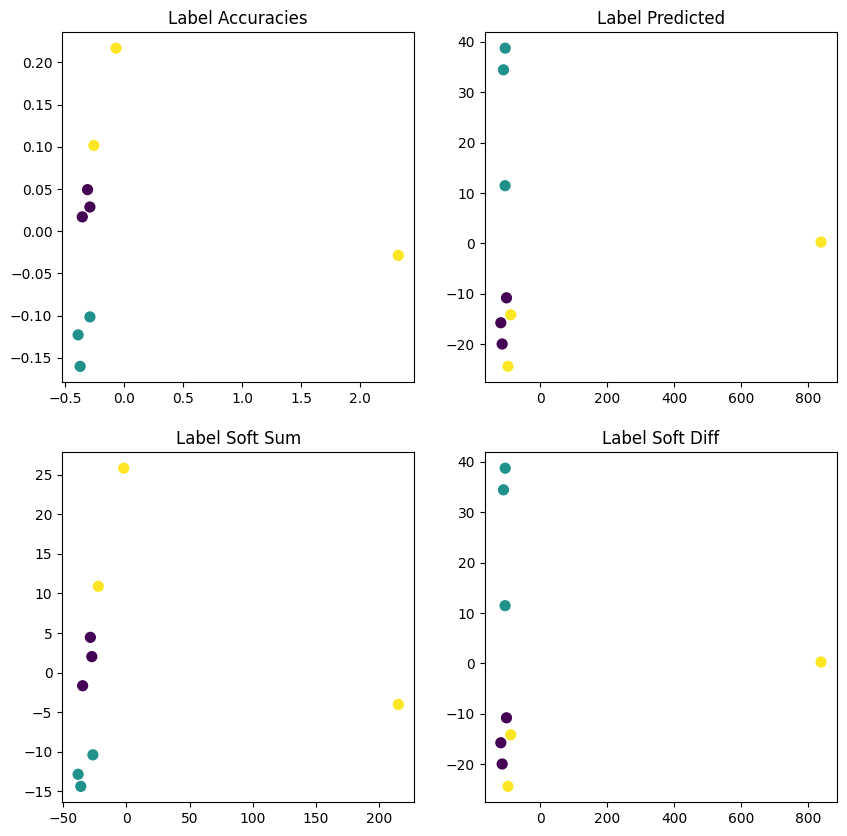

In [12]:
from sklearn.decomposition import PCA
# Instantiate PCA
pca = PCA(n_components=2)

# Apply PCA to the dataframes
label_accuracies_pca = pca.fit_transform(label_accuracies)
label_predicted_pca = pca.fit_transform(label_predicted)
label_soft_sum_pca = pca.fit_transform(label_soft_sum)
label_diff_pca = pca.fit_transform(label_diff)
transformed_data = pca.fit_transform(similarities)

# Create labels
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Scatter plots with larger dots
dot_size = 50
axs[0, 0].scatter(label_accuracies_pca[:, 0], label_accuracies_pca[:, 1], c=labels, s=dot_size)
axs[0, 0].set_title('Label Accuracies')
axs[0, 1].scatter(label_predicted_pca[:, 0], label_predicted_pca[:, 1], c=labels, s=dot_size)
axs[0, 1].set_title('Label Predicted')
axs[1, 0].scatter(label_soft_sum_pca[:, 0], label_soft_sum_pca[:, 1], c=labels, s=dot_size)
axs[1, 0].set_title('Label Soft Sum')
axs[1, 1].scatter(label_diff_pca[:, 0], label_diff_pca[:, 1], c=labels, s=dot_size)
axs[1, 1].set_title('Label Soft Diff')

plt.show()

In [13]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Scores
silhouette_accuracies = silhouette_score(label_accuracies_pca, labels)
silhouette_predicted = silhouette_score(label_predicted_pca, labels)
silhouette_soft_sum = silhouette_score(label_soft_sum_pca, labels)
silhouette_diff = silhouette_score(label_diff_pca, labels)
silhouette_transformed_data = silhouette_score(transformed_data, labels)

print('Silhouette Score for Accuracies:', silhouette_accuracies)
print('Silhouette Score for Predicted:', silhouette_predicted)
print('Silhouette Score for Soft Sum:', silhouette_soft_sum)
print('Silhouette Score for diff:', silhouette_diff)
print('Silhouette Score for Model params:', silhouette_transformed_data)



Silhouette Score for Accuracies: 0.21820794033076546
Silhouette Score for Predicted: 0.18891199068645134
Silhouette Score for Soft Sum: 0.16338534536840854
Silhouette Score for diff: 0.1889119906864522
Silhouette Score for Model params: 0.0


In [14]:
#df.sort_index(axis=1)

데이터 Cluster 별 모델 파라미터 분포

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


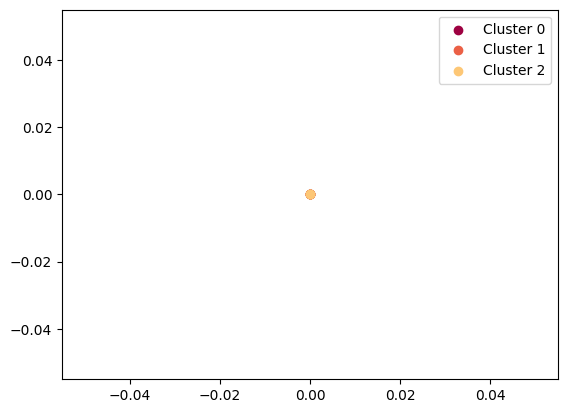

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit and transform your data to 2D
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(similarities)

# Assign labels based on index ranges
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 0.35, len(unique_labels)))

# Plot the transformed data with labels
for label, color in zip(unique_labels, colors):
    idx = np.where(labels == label)
    plt.scatter(transformed_data[idx, 0], transformed_data[idx, 1], color=color, label=f'Cluster {label}')

# Add a legend
plt.legend()

plt.show()
